# Tests retrieval capacity in our knowledge base

Inspired by: https://huggingface.co/learn/cookbook/advanced_ragv

## Imports

In [ ]:
!pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community matplotlib ipywidgets


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [14]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt
import glob
import json
import os
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

## Load our knowledge base

In [ ]:
# Define data folder
data_folder = "../outputs/"

### Official legal publication

We add to our context:
- EPC_guidelines
- EPC Articles and Rules
- PCT Articles and Rules
- Case Laws

In [ ]:
# Load all CSV
csv_files = glob.glob(f"{data_folder}/*.csv")
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame(columns=["ref", "url", "content"])

# List of documents for LangChain
csv_documents = [
    LangchainDocument(page_content=row["content"], metadata={"ref": row["ref"], "url": row["url"]})
    for _, row in tqdm(df.iterrows(), total=len(df))
]

  0%|          | 0/2310 [00:00<?, ?it/s]

In [5]:
# To visualize
# csv_documents

### Solutions to exam questions

In [7]:
# Load JSON with "solution" in their name
json_files = glob.glob(f"{data_folder}/*solution*.json")

json_documents = []
for file in json_files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    # Extract justification and create Langchain documents
    filename = os.path.basename(file)  # Nom du fichier sans le chemin
    for key, entry in data.items():
        if "Justification" in entry:
            json_documents.append(
                LangchainDocument(
                    page_content=entry["Justification"],
                    metadata={"ref": filename}  # ref = Nom du fichier
                )
            )

In [9]:
# To visualize
# json_documents

### Fusion of our knowledge

In [ ]:
# Fusionner les données des CSV et JSON
RAW_KNOWLEDGE_BASE = csv_documents + json_documents

print(f"Total of documents loading : {len(RAW_KNOWLEDGE_BASE)}")

Total documents chargés : 2354


## Split documents into chunck

  0%|          | 0/7562 [00:00<?, ?it/s]

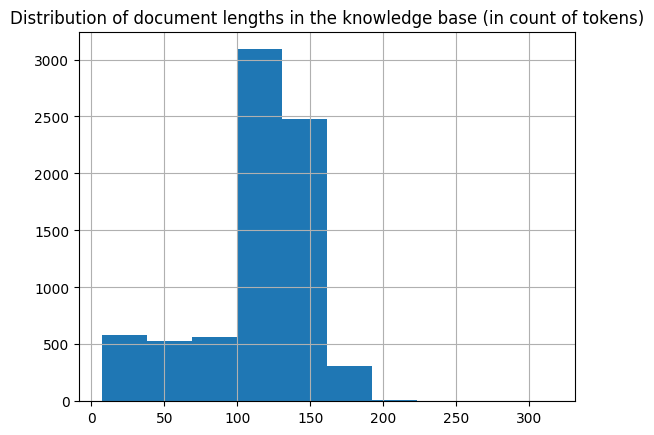

In [15]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

```
Note à moi même:

Voir pourquoi cette répartition, surement un problème de séparateurs. Améliorer ça.

```

## Building the vector database

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},  # replace 'cpu' by 'cuda' if you have Nvidia gpu
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

In [ ]:
# Compute embeddings (can take time ~7min on my laptop)
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [20]:
# Save embeddings
KNOWLEDGE_VECTOR_DATABASE.save_local("../outputs/rag_embeddings")

In [ ]:
# Load embeddings
KNOWLEDGE_VECTOR_DATABASE = FAISS.load_local("rag_embeddings", embedding_model, DistanceStrategy.COSINE)

## Visualise embeddings

## Try Retrieval

In [21]:
user_query = "You represent a client whose European patent has been opposed. The opposition division decides to maintain the patent in amended form. The invitation with the three-month time limit under Rule 82(2) EPC is sent on 16 August 2021, but proceedings are interrupted under Rule 142 EPC on 20 October 2021. The problems are resolved and the proceedings resume on 16 January 2022. When does the time limit under Rule 82(2)EPC end?"

In [26]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n========================== Retrieved Documents ==========================")
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"\n========================== Document {i} ==========================")
    print(doc.page_content)
    print("\n========================== Metadata ==========================")
    print(doc.metadata)


Starting retrieval for user_query='You represent a client whose European patent has been opposed. The opposition division decides to maintain the patent in amended form. The invitation with the three-month time limit under Rule 82(2) EPC is sent on 16 August 2021, but proceedings are interrupted under Rule 142 EPC on 20 October 2021. The problems are resolved and the proceedings resume on 16 January 2022. When does the time limit under Rule 82(2)EPC end?'...

========================== Retrieved Documents ==========================

========================== Document 1 ==========================
to the proceedings or a third party fails to comply with a time limit laid down in the EPC or fixed by the EPO, this will result in a loss of rights in certain cases specified in the EPC, without any decision concerning the refusal of the European patent application or the grant, revocation or maintenance of the European patent, or the taking of evidence. Rule 112

========================== 